<a href="https://colab.research.google.com/github/AmanullaChishty/Pytorch/blob/main/PyTorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setup


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
!pip install -q torchinfo

In [3]:
from torchinfo import summary

In [4]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 4183 (delta 65), reused 99 (delta 41), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (2436/2436), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [6]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. Creating an EffNetB2 feature extractor

In [8]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 78.5MB/s]


In [9]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3)
)

In [11]:
def create_effnetb2_model(num_classes:int=3,seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [12]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=42)

In [13]:
summary(effnetb2_model, input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [15]:
# Training EffnetB2 feature extractor

from going_modular.going_modular import engine

optimizer = optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0944 | train_acc: 0.3672 | test_loss: 0.9196 | test_acc: 0.7538
Epoch: 2 | train_loss: 0.8722 | train_acc: 0.8164 | test_loss: 0.8314 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.7758 | train_acc: 0.7969 | test_loss: 0.7712 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7183 | train_acc: 0.7539 | test_loss: 0.6689 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6660 | train_acc: 0.7969 | test_loss: 0.6608 | test_acc: 0.8362
Epoch: 6 | train_loss: 0.5716 | train_acc: 0.9375 | test_loss: 0.5944 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.5211 | train_acc: 0.9375 | test_loss: 0.5685 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.5763 | train_acc: 0.8008 | test_loss: 0.5712 | test_acc: 0.8674
Epoch: 9 | train_loss: 0.5263 | train_acc: 0.8086 | test_loss: 0.5325 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.4848 | train_acc: 0.8281 | test_loss: 0.4664 | test_acc: 0.9176


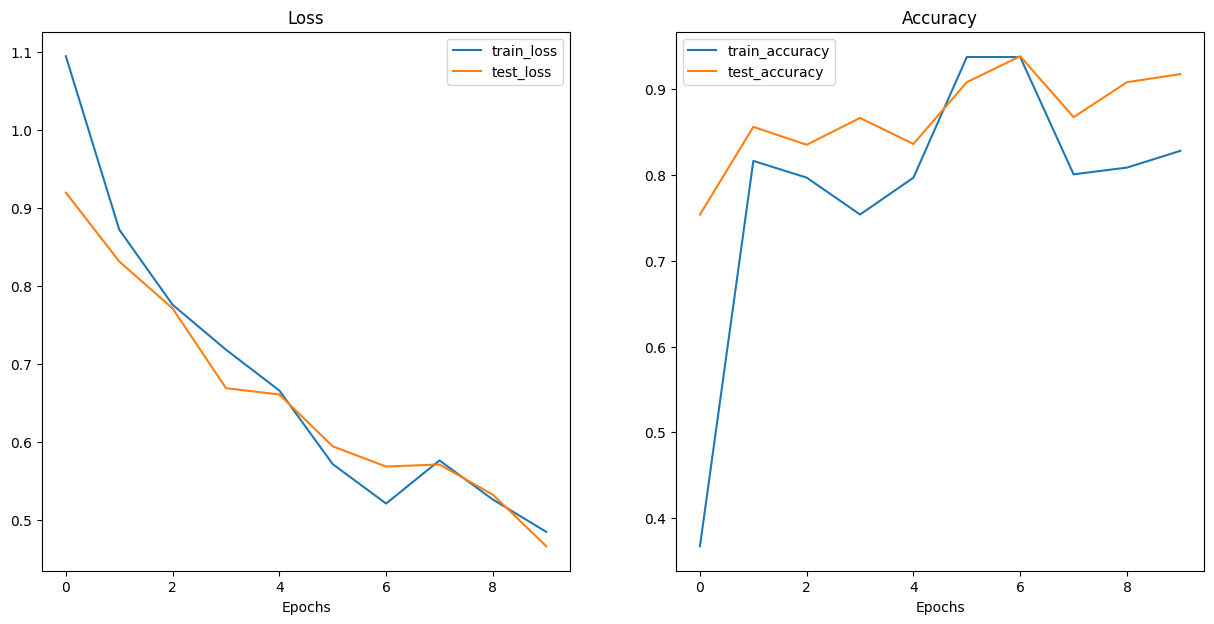

In [16]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

In [17]:
# Saving EffNetB2 feature extractor

from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/09_effnetb2_feature_extractor.pth


In [18]:
# Checking the size of model

from pathlib import Path

model_path = Path("models/09_effnetb2_feature_extractor.pth")
pretrained_effnetb2_model_size=model_path.stat().st_size//(1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [19]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [20]:
# Dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.46639881531397503,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3. Creating a ViT feature extractor

In [21]:
vit = torchvision.models.vit_b_16()
# vit.heads()

In [22]:
def create_vit_model(num_classes:int=3,seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [23]:
vit,vit_transforms = create_vit_model(num_classes=3,seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


In [24]:
summary(
    vit,
    input_size=(32,3,224,224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [25]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

In [26]:
#Training ViTfeature extractor

from going_modular.going_modular import engine

optimizer = optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7768 | train_acc: 0.6992 | test_loss: 0.5612 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3794 | train_acc: 0.9180 | test_loss: 0.3352 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2297 | train_acc: 0.9414 | test_loss: 0.2830 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1641 | train_acc: 0.9570 | test_loss: 0.2517 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1322 | train_acc: 0.9766 | test_loss: 0.2329 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.1399 | train_acc: 0.9688 | test_loss: 0.2184 | test_acc: 0.9186
Epoch: 7 | train_loss: 0.1155 | train_acc: 0.9648 | test_loss: 0.2389 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0875 | train_acc: 0.9844 | test_loss: 0.2253 | test_acc: 0.8883
Epoch: 9 | train_loss: 0.1564 | train_acc: 0.9766 | test_loss: 0.2013 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0815 | train_acc: 0.9805 | test_loss: 0.1756 | test_acc: 0.9176


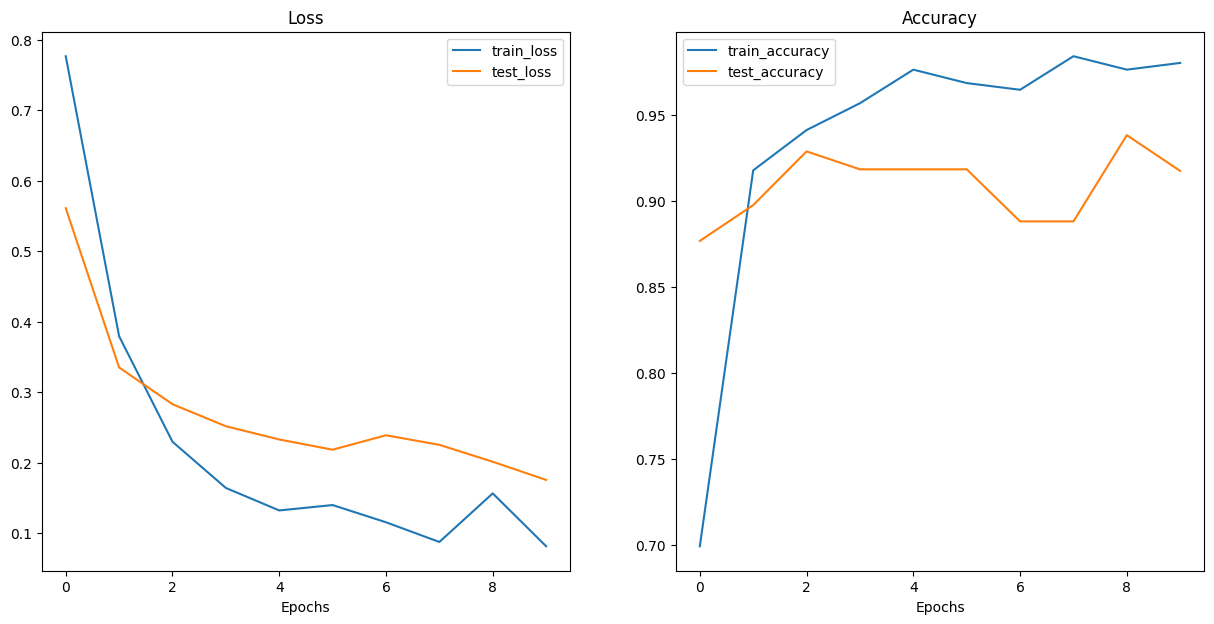

In [27]:
plot_loss_curves(vit_results)

In [28]:
#Save the model

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_vit_feature_extractor.pth")

[INFO] Saving model to: models/09_vit_feature_extractor.pth


In [29]:
model_path = Path("models/09_vit_feature_extractor.pth")
pretrained_vit_model_size=model_path.stat().st_size//(1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [30]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [31]:
# ViT Statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.17558992405732474,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 4. Making Predictions with trained models and timing them

In [32]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


[PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg')]

In [33]:
from pickle import encode_long
import pathlib
import torch
import torchvision
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names: List[str],
                   device:str="cuda" if torch.cuda.is_available() else "cpu")->List[Dict]:


      pred_list = []

      for path in tqdm(paths):
        pred_dict = {}

        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()
        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(dim=0).to(device)
        model.to(device)
        model.eval()

        with torch.inference_mode():
          pred_logits = model(transformed_image)
          pred_prob = torch.softmax(pred_logits, dim=1)
          pred_label = torch.argmax(pred_prob, dim=1)
          pred_class = class_names[pred_label.cpu()]

          pred_dict["pred_class"] = pred_class
          pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)

          end_time = timer()
          pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

      return pred_list


In [34]:
# Make predictions across test dataset with EffNetB2

effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [35]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.789,
  'time_for_pred': 0.4001,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.5992,
  'time_for_pred': 0.1867,
  'correct': True}]

In [36]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/1925494.jpg,pizza,pizza,0.7890,0.4001,True
1,data/pizza_steak_sushi/test/pizza/1503858.jpg,pizza,pizza,0.5992,0.1867,True
2,data/pizza_steak_sushi/test/pizza/3092704.jpg,pizza,pizza,0.5673,0.1832,True
3,data/pizza_steak_sushi/test/pizza/398345.jpg,pizza,pizza,0.6315,0.1629,True
4,data/pizza_steak_sushi/test/pizza/416067.jpg,pizza,pizza,0.5739,0.1588,True


In [37]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,69
False,6


In [38]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1249 seconds


In [39]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.46639881531397503,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1249}

## 5. Making and timing predictions with ViT

In [40]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [41]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.9895,
  'time_for_pred': 0.7711,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.9926,
  'time_for_pred': 0.5655,
  'correct': True}]

In [42]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/1925494.jpg,pizza,pizza,0.9895,0.7711,True
1,data/pizza_steak_sushi/test/pizza/1503858.jpg,pizza,pizza,0.9926,0.5655,True
2,data/pizza_steak_sushi/test/pizza/3092704.jpg,pizza,pizza,0.9966,0.5411,True
3,data/pizza_steak_sushi/test/pizza/398345.jpg,pizza,pizza,0.9968,0.6349,True
4,data/pizza_steak_sushi/test/pizza/416067.jpg,pizza,pizza,0.9942,0.9068,True


In [43]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,69
False,6


In [44]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.5905 seconds


In [45]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.17558992405732474,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.5905}

## 6. Comparing model results, prediction times and size

In [46]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT "]

df["test_acc"] = round(df["test_acc"]*100,2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.466399,91.76,7705221,29,0.1249,EffNetB2
1,0.175590,91.76,85800963,327,0.5905,ViT


/bin/bash: line 1: mdkir: command not found


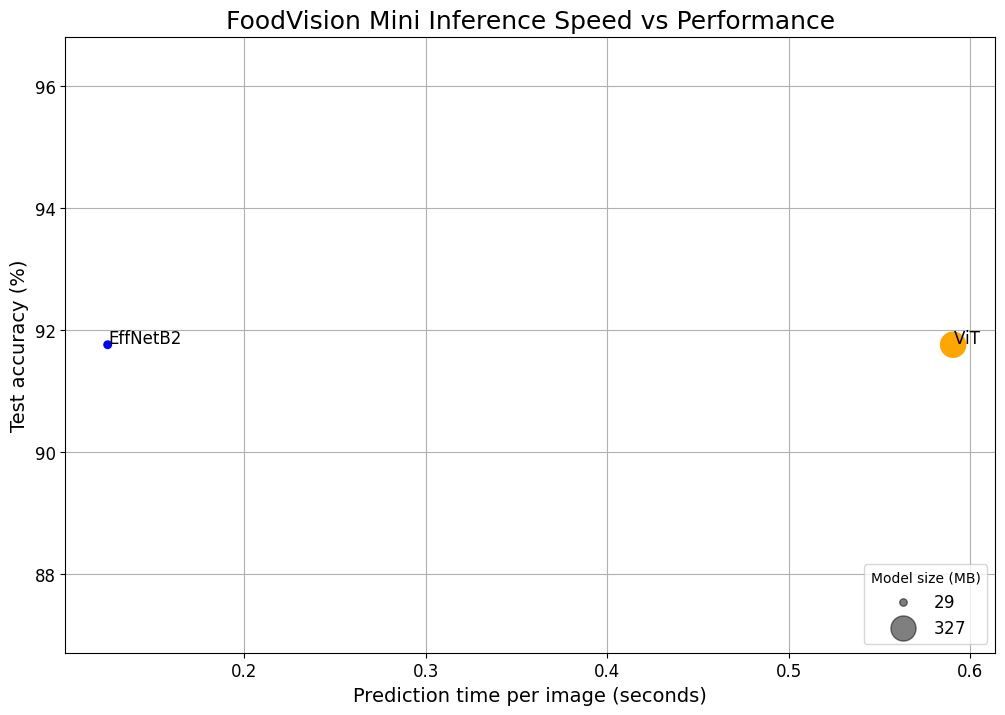

In [47]:
# Plot to compare model performance from the DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mdkir images/
plt.savefig("data/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Creating a Gradio demo

In [48]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.5 MB/s eta 0:00:00
Gradio version: 4.42.0


In [49]:
effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [50]:
#Creating a function to map our inputs and outputs
from typing import Tuple

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()
  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer()-start_time, 5)

  return pred_labels_and_probs, pred_time

In [51]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

random_image_path = random.sample(test_data_paths,k=1)[0]
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi/test/pizza/2871261.jpg

Prediction label and probability dictionary: 
{'pizza': 0.7467997074127197, 'steak': 0.19827906787395477, 'sushi': 0.05492116138339043}
Prediction time: 0.10092 seconds


In [52]:
# Create a list of example imputs
example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi/test/sushi/46797.jpg',
 'data/pizza_steak_sushi/test/pizza/540882.jpg',
 'data/pizza_steak_sushi/test/sushi/1600999.jpg']

In [53]:
!pip -q install gradio

In [54]:
import gradio as gr

title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify food images into pizza, steak or sushi."

demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description)

demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable link?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4cee545c25d7793bdc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning the Gradio into a deployable App

In [55]:
# Creatinga folder to store the App files

import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

In [56]:
#Creating a folder of example images to use with our FoodVision Mini demo

import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path/"examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
                            Path('data/pizza_steak_sushi/test/steak/100274.jpg'),
                            Path('data/pizza_steak_sushi/test/pizza/1152100.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path/example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi/test/sushi/1172255.jpg to demos/foodvision_mini/examples/1172255.jpg
[INFO] Copying data/pizza_steak_sushi/test/steak/100274.jpg to demos/foodvision_mini/examples/100274.jpg
[INFO] Copying data/pizza_steak_sushi/test/pizza/1152100.jpg to demos/foodvision_mini/examples/1152100.jpg


In [57]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/100274.jpg'], ['examples/1172255.jpg'], ['examples/1152100.jpg']]

In [58]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth: False


In [59]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [60]:
## Turning our FoodVision Mini Gradio app into a Python script (app.py)
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [61]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt
